In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from scipy.stats import multivariate_normal
from sklearn.datasets import make_spd_matrix
import cv2 as cv
from PIL import Image
from numpy import asarray
from scipy import linalg
from scipy.special import logsumexp
import statistics

# Gaussian Mixture Model
* Expectation Maximization algorithm mentioned in the class
* fit() is called to start this EM algorithm

In [ ]:
class GMM:
  def __init__(self, k, verbose=False, graphing=False, epoch = 1e2, reg = 1e-4, epsilon=1e-3, description = ""):
    """
      # Parameters
        k = hyperparameter which gives number of GMM mixtures
        verbose = gives epoch and mean update after every iteration [default = False]
        graphing = gives log-likelihood graph after the iteration [default = False]
        epoch = number of iterations to run [default = 1e-2]
        reg = regularization constant added to covariance for numerical stability [default = 1e-4]
        epsilon = minimum norm threshold to terminate the iterations [default = 1e-3]

      # Returns
        * None
        * Initializes the parameters to self
    """
    self.k = k
    # self.D = dimension
    self.verbose = verbose
    self.epoch = epoch
    self.graphing = graphing
    self.reg = reg
    self.epsilon = epsilon
    self.likelihood_history=[] # Record sum of likelihood after each iterations (important)
    self.description = description

  def init_params(self, X):
    """
      # Parameters
        X = input data of size (N, D)

      # Returns
        * None
        * Initializes the required mean, covariance, posterior and likelihood
    """
    self.prior = np.ones(self.k, dtype=float)/self.k # (K,) ; equal priors during initialization, weight

    # self.means = [np.random.choice(X[:, i], size=self.k) for i in range(X.shape[1])] # (K x D)
    x_split = np.array_split(X, self.k, axis=0) 
    self.means = [np.mean(data, axis=0) for data in x_split] # (K x D)
    self.means = np.array(self.means) # match the columns with each dimension of X

    self.cov = [make_spd_matrix(X.shape[1]) for i in range(self.k)] # (K x D x D)
    self.cov = np.array(self.cov)

    self.posterior = np.zeros((X.shape[0], self.k), dtype=float)
    self.likelihood = np.zeros((X.shape[0], self.k), dtype=float)

  def fit(self, X):
    """
      # Parameters
        X = input data of size (N, D)
      
      # Returns
        * None
        * Updates the mean, covariance and likelihood variables
    """
    # initialization of hyperparameters
    self.init_params(X)
    # self.likelihood_history=[]
    oldcov = np.copy(self.cov)
    norm=100 # initialize this norm
    t=0
    
    # break the loop if either epoch is reached or norm is less than epsilon
    while(t<self.epoch and norm>self.epsilon): 
      # Expectation Step
      # calculate the normalization constant
      norm = self.normalization(X, self.likelihood, self.prior, self.means, self.cov)
      # use the bayesian theorem formula to get posterior --> POSTERIOR = (LIKELIHOOD * PRIOR)/NORMALIZATION
      self.posterior = self.expectation(X, self.prior, self.means, self.cov, norm)
      # print(self.posterior.shape)

      # this value will be subtracted from updated norm to get epsilon
      norm_temp = np.copy(norm)

      # Maximization Step
      # update mean, covariance and prior in this method
      self.maximization(X)
      
      # if this norm is < than epsilon then break the loop
      norm = np.linalg.norm(oldcov - self.cov)
      
      # old covariance will be the current covariance
      oldcov = np.copy(self.cov)

      t+=1
      # Verbose if enabled
      if(self.verbose):
        print("%d Epoch Completed" % t)
        print("Mean: \n", self.means)
      # print("%d Epoch Completed" % t)
        
      # self.likelihood_history.append(np.log10(np.sum(self.likelihood, axis=0))) #changed this
      self.likelihood_history.append(np.log10(np.sum(norm_temp)))
    
    print("Cluster %d converged in %d/%d epoch with norm of %.8f" %(self.k, t, self.epoch, norm))
    # print(norm)
    # print(self.epsilon)
    # print(norm>self.epsilon)

    # Graphing if enabled then displays likelihood graph
    if(self.graphing):
      likelihood = np.array(self.likelihood_history)
      # print(np.array(model.likelihood_history).shape)
      fig1 = plt.figure(figsize=(18,10))
      # for i in range(K):
        # plt.plot(np.arange(t), likelihood[:, i], label=str(i+1))
      plt.plot(np.arange(t), likelihood)
      plt.xlabel("Epoch")
      plt.ylabel("Likelihood")
      plt.title("Log-Likelihood vs Iterations for %s" %self.description)
      # plt.legend(loc="best")
      plt.show()
    
  def normalization(self, X, likelihood, prior, mean, cov):
    """
      # Parameters
        X --> N, D
        prior --> K,
        mean --> K, D
        cov --> K, D, D
      
      # Returns
        normalization --> N,
    """
    for k in range(self.k):
      self.likelihood[:, k] = multivariate_normal(mean[k, :], cov[k, :]).pdf(X)
    normalization = self.prior*self.likelihood
    normalization = np.sum(normalization, axis=-1) # add all the cluster's likelihood

    # print(normalization.shape)
    assert self.likelihood.shape == (X.shape[0], self.k) # for verification
    assert normalization.shape == (X.shape[0],) # for verification

    return normalization

  def expectation(self, X, prior, mean, cov, norm):
    """
    # Parameters
      X = input data with size N, D
      prior = prior mean with size K,
      mean = size K, D
      cov = size K, D, D
      norm = normalization constant got from normalization() method with size N,

    # Returns 
      posterior = probability with size N, K
    """
    for k in range(self.k):
      self.posterior[:, k] = multivariate_normal(mean[k,:], cov[k,:]).pdf(X)
      self.posterior[:, k] = self.posterior[:, k] / norm
    self.posterior *= self.prior

    assert self.posterior.shape == (X.shape[0], self.k) # for verification

    return self.posterior

  def maximization(self, X):
    """
      # Parameters
        X = input data with size (N, D)

      # Returns
        * None
        * Updates mean, covariance, and prior
    """
    N = X.shape[0]

    w = np.sum(self.posterior, axis=0)
    self.prior = w / N
    assert self.prior.shape == (self.k, )

    for k in range(self.k):
      # print(np.sum(self.posterior[:, k].reshape(-1,1) * X, axis=0).shape)
      self.means[k, :] = np.sum(self.posterior[:, k].reshape(-1,1) * X, axis=0) / w[k]
    assert self.means.shape == (self.k, X.shape[1])

    cov_reg = np.eye(X.shape[1]) * self.reg
    for k in range(self.k):
      self.cov[k] = np.dot((self.posterior[:, k].reshape(-1,1) * (X - self.means[k,:])).T, (X - self.means[k,:]))
      # self.cov[k] = (self.posteior[:,k].reshape(-1,1) * (X-self.mean[k,:]))
      self.cov[k] = self.cov[k] / w[k]
      self.cov[k] += cov_reg
    assert self.cov.shape == (self.k, X.shape[1], X.shape[1])
 
    return None

  def predict_img(self, X):
    """
      # Parameters
        X = input data with size N, D

      # Returns
        labeled_img = returns the pixels correspondence to which cluster with size N,
    """
    labeled_img = np.zeros(X.shape)
    labeled_pixel = np.zeros(X.shape[0], dtype=int)
    
    labeled_pixel = np.argmax(self.likelihood, axis=-1)

    labeled_img = self.means[labeled_pixel]

    return labeled_img

  #starts here

  def cost_Fucntion(self,X):

    number_of_free_param = (X.shape[1] * self.k)*2 + self.k

    return (-2 * self.score(X) * X.shape[0]) + (number_of_free_param * np.log(
            X.shape[0]))
    
  def score(self, X):

    return statistics.mean(self.score_samples(X))

  def score_samples(self, X):

    return logsumexp(self._estimate_weighted_log_prob(X), axis=1)

  def _estimate_weighted_log_prob(self, X):

    return self._estimate_log_prob(X) + self._estimate_log_weights()

  def _estimate_log_weights(self):
        return np.log(self.prior)

  def _estimate_log_prob(self, X):

    cholesky = self.cholesky_precision(self.cov)
    det_cholesky = self._compute_log_det_cholesky(cholesky, X.shape[1])

    return self._estimate_log_gaussian_prob(X, self.means, cholesky,
          det_cholesky, self.cov)
    

  def _estimate_log_gaussian_prob(self, X, means, precision_cholesky, log_det, covariances):

    n_samples, n_features = X.shape
    n_components, _ = means.shape

    precisions_chol = precision_cholesky
    

    log_prob = np.empty((n_samples, n_components))
    for k, (mu, prec_chol) in enumerate(zip(means, precisions_chol)):
        y = np.dot(X, prec_chol) - np.dot(mu, prec_chol)
        log_prob[:,k] = np.sum(np.square(y), axis=1)

    return - 0.5 * (n_features * np.log(2 * np.pi) + log_prob) + log_det


  # from https://fossies.org/dox/scikit-learn-1.0.2/__gaussian__mixture_8py_source.html
  def cholesky_precision(self,covariance):
    k, d, _ = covariance.shape
    precision_cholesky = np.empty((k, d, d))
    for n, covariances in enumerate(covariance):
        try:
            cov_chol = linalg.cholesky(covariances, lower=True)
        except linalg.LinAlgError:
            raise ValueError("Cholesky decomposition failed.")
        precision_cholesky[n] = linalg.solve_triangular(cov_chol, 
            np.eye(d), lower=True).T
    return precision_cholesky

  def _compute_log_det_cholesky(self, matrix, d):

    k, _, _ =  matrix.shape
    log_det_chol = (np.sum(np.log(matrix.reshape(k, 
        -1)[:,::d+ 1]),axis=1))
    return log_det_chol


# Gaussian Blur
* Blur kernel determined by user (3x3), (5x5) and (7x7)
* Using Gaussian blur to do blurring of image to reduce noise

In [ ]:
import skimage.io
import matplotlib.pyplot as plt
import skimage.filters

def gaussian_blur(image, sigma=3):

  # apply Gaussian blur, creating a new image
  blurred = skimage.filters.gaussian(
      image, sigma=(sigma, sigma), truncate=3.5, multichannel=True)
  return blurred

# Main Body Code
## Normalization
*  Normalize the data by converting RGB values from [0, 255] --> [0, 1]

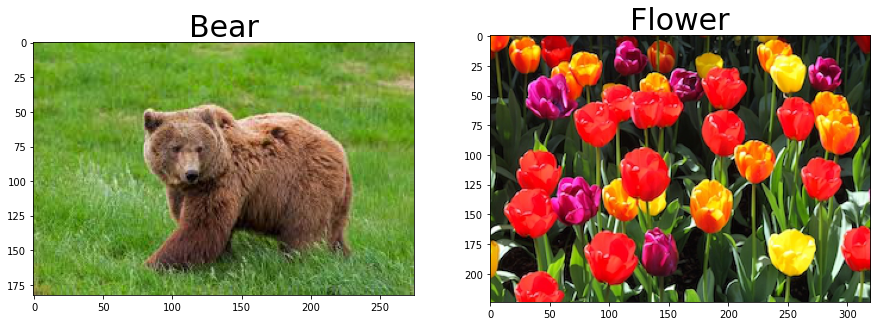

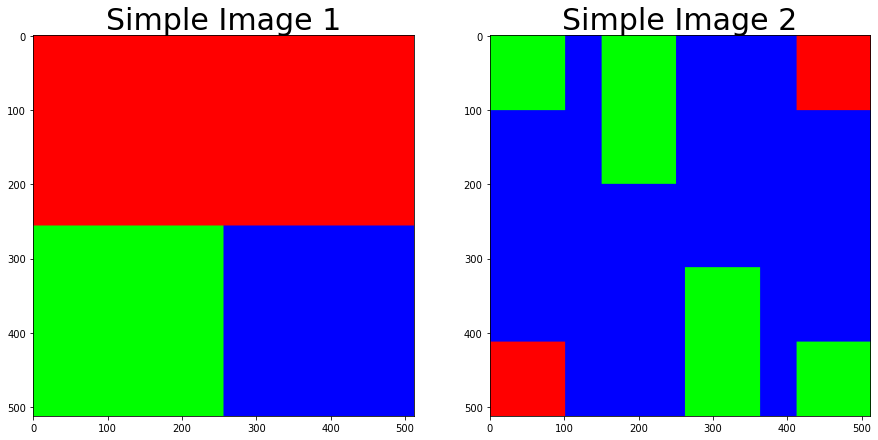

In [ ]:
fig1 = plt.figure(figsize=(15, 25))

# importing bear image and normalize it to [0,1]
bear_orig = image.imread("bear.jpeg")
bear_copy = bear_orig.copy()
fig1.add_subplot(1, 2, 1)
plt.title("Bear", fontsize=30)
plt.imshow(bear_copy)
# bear_copy = bear_copy.reshape(-1, 3)
bear_copy = bear_copy/255.

# importing flower image and normalize it to [0, 1]
flower_orig = image.imread("flower.jpeg")
flower_copy = flower_orig.copy()
fig1.add_subplot(1, 2, 2)
plt.title("Flower", fontsize=30)
plt.imshow(flower_copy)
# flower_copy = flower_copy.reshape(-1, 3)
flower_copy = flower_copy/255.

fig2 = plt.figure(figsize=(15, 25))
w, h = 512, 512
data = np.zeros((h, w, 3), dtype=np.uint8)

data[:,:] = [248,248,255]

#simple1
w, h = 512, 512
data = np.zeros((h, w, 3), dtype=np.uint8)

data[0:256, 0:512] = [255,0,0]
data[256:512, 0: 256] = [0, 255,0]
data[256:512, 256:512] = [0,0,255]

simple1  = Image.fromarray(data, 'RGB')
simple_img1_orig= asarray(simple1)

fig2.add_subplot(1, 2, 1)
plt.title("Simple Image 1", fontsize=30)
plt.imshow(simple1)
# plt.show()

simple_img1_copy = simple_img1_orig.reshape(-1, 3)
simple_img1_copy = simple_img1_copy/255

#simple2
w, h = 512, 512
data = np.zeros((h, w, 3), dtype=np.uint8)

data[:,:] = [0,0,255]


#red 
data[412:512, 0:101] = [255,0 ,0]
data[0:101,412:512] = [255,0 ,0]

#brown
data[0:101, 0:101] = [0,255,0]
data[412:512, 412:512] = [0,255,0]

#blue 
data[0:200, 262:363] = [0,0,255]
data[312:512, 150:250] = [0,0,255]

#green
data[0:200, 150:250] = [0,255,0]
data[312:512, 262:363] = [0,255,0]



simple2  = Image.fromarray(data, 'RGB')
simple_img2_orig= asarray(simple2)

#plot image
fig2.add_subplot(1, 2, 2)
plt.title("Simple Image 2", fontsize=30)
plt.imshow(simple2)

simple_img2_copy = simple_img2_orig.reshape(-1, 3)
simple_img2_copy = simple_img2_copy/255

## Blurring Two Images

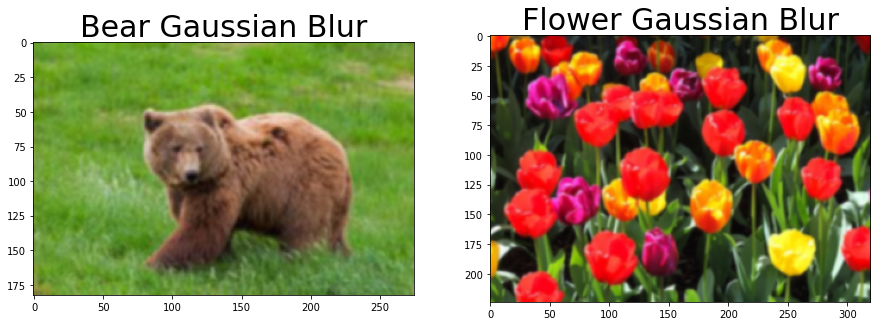

In [ ]:
# bear_copy = bear_copy.reshape(bear_orig.shape)
# flower_copy = flower_copy.reshape(flower_orig.shape)
bear_copy_blur = gaussian_blur(bear_copy, sigma=1)
flower_copy_blur = gaussian_blur(flower_copy, sigma=1)

fig3 = plt.figure(figsize=(15, 25))
fig3.add_subplot(1, 2, 1)
plt.title("Bear Gaussian Blur", fontsize=30)
plt.imshow(bear_copy_blur)

fig3.add_subplot(1, 2, 2)
plt.title("Flower Gaussian Blur", fontsize=30)
plt.imshow(flower_copy_blur)

bear_copy_blur = bear_copy_blur.reshape(-1, 3)
flower_copy_blur = flower_copy_blur.reshape(-1, 3)

## Test # 1
### Simple Image Testing
* K = 3

Cluster 3 converged in 4/500 epoch with norm of 0.00000000
Cluster 3 converged in 14/500 epoch with norm of 0.00000000


(-0.5, 511.5, 511.5, -0.5)

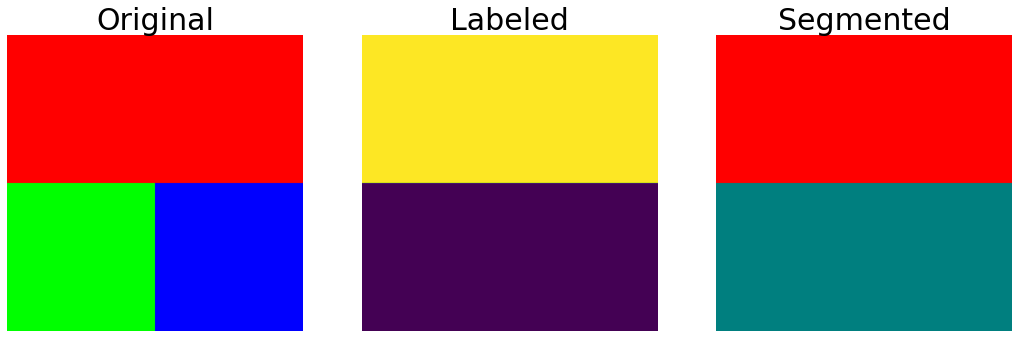

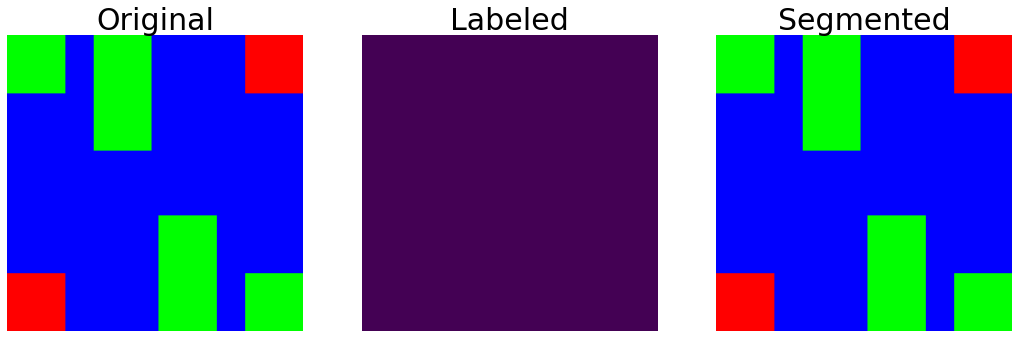

In [ ]:
K=3
epoch=500
epsilon=1e-8
verbose = False

model = GMM(K, verbose=verbose, graphing=False, epoch=epoch, epsilon=epsilon)
model.fit(simple_img1_copy)

labeled_img_simple_image1 = model.predict_img(simple_img1_copy)
labeled_img_simple_image1 = np.array(labeled_img_simple_image1 * 255, dtype=int)
labeled_img_simple_image1 = labeled_img_simple_image1.reshape(simple_img1_orig.shape)

fig = plt.figure(figsize=(18,20))

# fig, ax = plt.subplots()

fig.add_subplot(1, 3, 1)
plt.imshow(simple_img1_orig) #
plt.title("Original", fontsize=30)
plt.axis('off')

fig.add_subplot(1, 3, 2)
plt.imshow(np.mean(labeled_img_simple_image1 , axis=-1))
plt.title("Labeled", fontsize=30)
plt.axis('off')

fig.add_subplot(1, 3, 3)
plt.imshow(labeled_img_simple_image1 )
plt.title("Segmented", fontsize=30)
plt.axis('off')

#segmenting simple image2

K=3
epoch=500
epsilon=1e-8
verbose = False

model = GMM(K, verbose=verbose, graphing=False, epoch=epoch, epsilon=epsilon)
model.fit(simple_img2_copy)

labeled_img_simple_image2 = model.predict_img(simple_img2_copy)
labeled_img_simple_image2 = np.array(labeled_img_simple_image2 * 255, dtype=int)
labeled_img_simple_image2 = labeled_img_simple_image2.reshape(simple_img2_orig.shape)

fig = plt.figure(figsize=(18,20))

fig.add_subplot(1, 3, 1)
plt.imshow(simple_img2_orig) #
plt.title("Original", fontsize=30)
plt.axis('off')

fig.add_subplot(1, 3, 2)
plt.imshow(np.mean(labeled_img_simple_image2 , axis=-1))
plt.title("Labeled", fontsize=30)
plt.axis('off')

fig.add_subplot(1, 3, 3)
plt.imshow(labeled_img_simple_image2)
plt.title("Segmented", fontsize=30)
plt.axis('off')


## TEST 2


1.   Bear BIC 

Cluster 2 converged in 59/500 epoch with norm of 0.00000001
Cluster 3 converged in 84/500 epoch with norm of 0.00000001
Cluster 4 converged in 214/500 epoch with norm of 0.00000001
Cluster 5 converged in 164/500 epoch with norm of 0.00000001
Cluster 6 converged in 500/500 epoch with norm of 0.00000100
Cluster 7 converged in 175/500 epoch with norm of 0.00000001


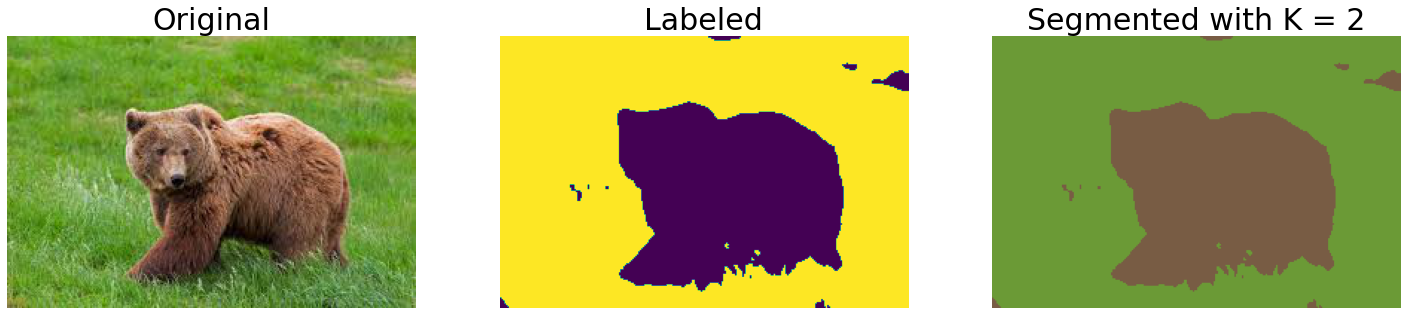

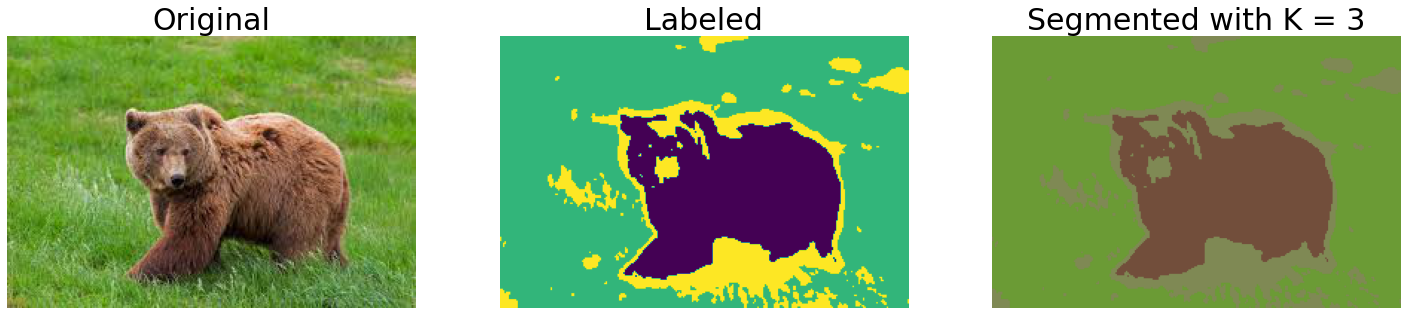

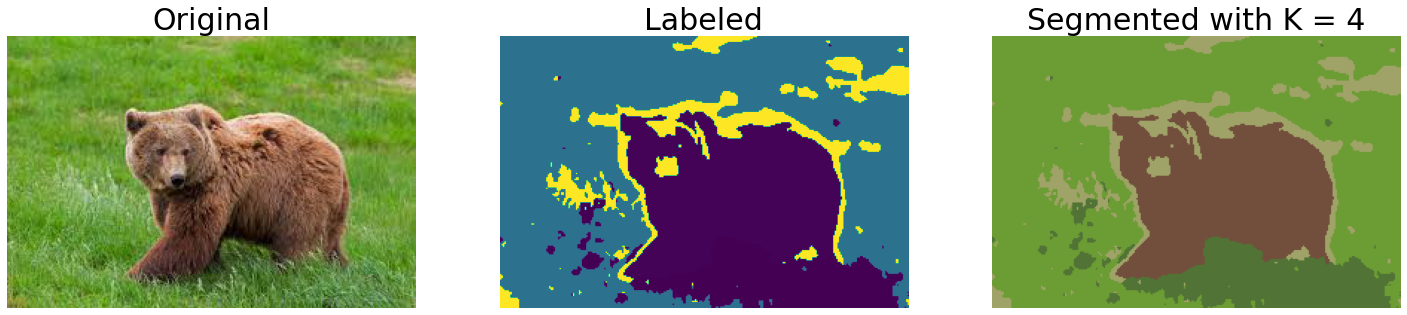

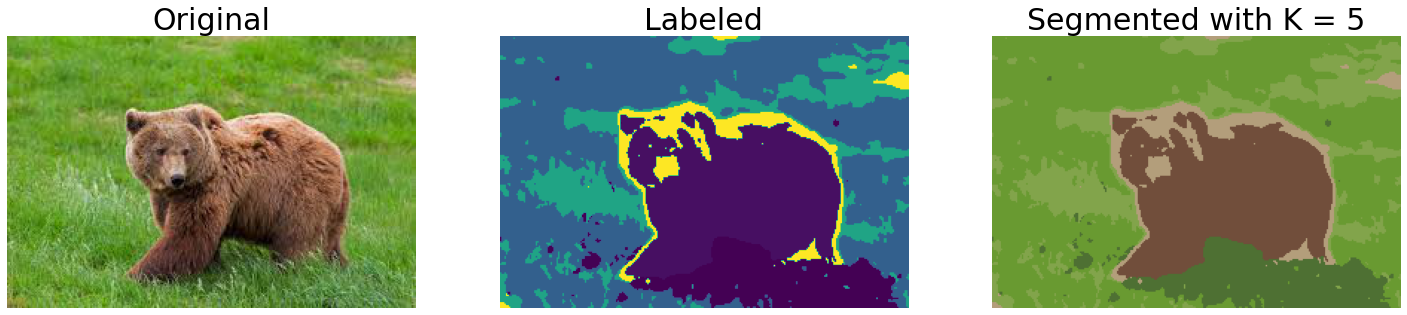

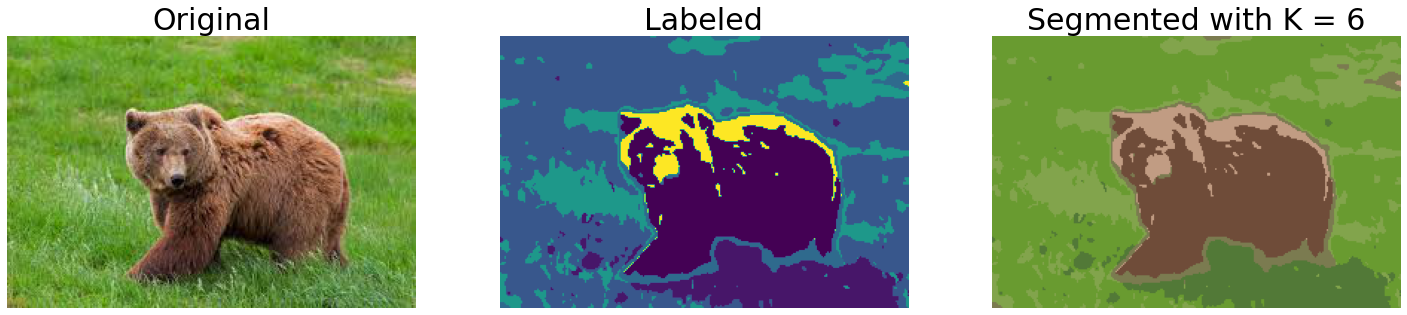

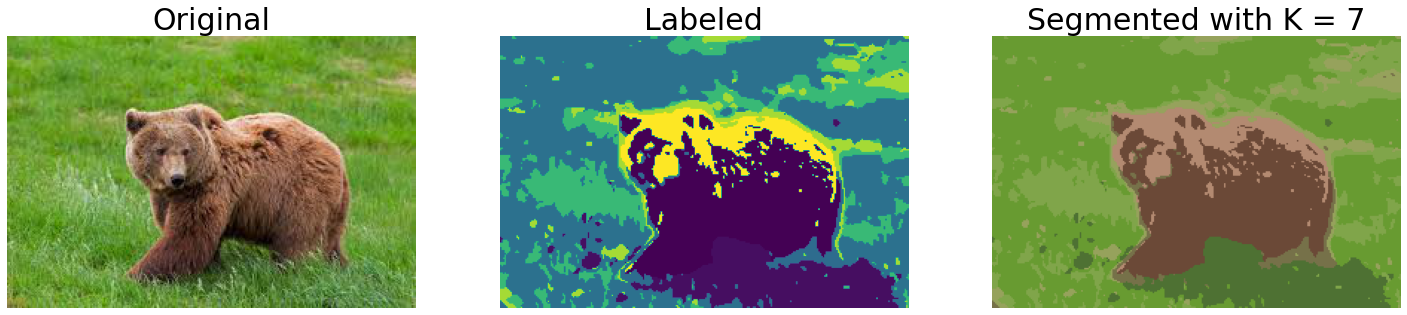

In [ ]:
K=7
epoch=500
epsilon=1e-8
Verbose = False
Graphing = False

#for bear
BIC_list =[]
n_components = np.arange(2,8)
t=0
for n in n_components:
  temp = GMM(n, verbose=Verbose, graphing = Graphing, epoch=epoch, epsilon=epsilon)
  temp.fit(bear_copy_blur)
  labeled_img = temp.predict_img(bear_copy_blur)
  labeled_img  = np.array(labeled_img * 255, dtype=int)

  labeled_img = labeled_img.reshape(bear_orig.shape) #
  # print(labeled_img.shape)

  fig = plt.figure(figsize=(25,35))

  t+=1
  fig.add_subplot(6, 3, t)
  plt.imshow(bear_orig)
  plt.title("Original", fontsize=30)
  plt.axis('off')

  t+=1
  fig.add_subplot(6, 3, t)
  plt.imshow(np.mean(labeled_img, axis=-1))
  plt.title("Labeled", fontsize=30)
  plt.axis('off')

  t+=1
  fig.add_subplot(6, 3, t)
  plt.imshow(labeled_img)
  plt.title("Segmented with K = %d"%n, fontsize=30)
  plt.axis('off')

  # plt.title("K = %d"%n)

  BIC_list.append(temp.cost_Fucntion(bear_copy_blur))

plt.show()

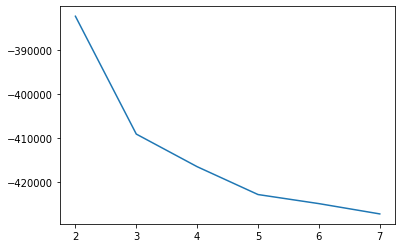

In [ ]:
plt.plot(n_components, BIC_list)
plt.show()

## Test # 3


1.   BIC for flower




Cluster 5 converged in 76/500 epoch with norm of 0.00000088
Cluster 6 converged in 495/500 epoch with norm of 0.00000094
Cluster 7 converged in 147/500 epoch with norm of 0.00000099
Cluster 8 converged in 178/500 epoch with norm of 0.00000097
Cluster 9 converged in 229/500 epoch with norm of 0.00000093
Cluster 10 converged in 383/500 epoch with norm of 0.00000098
Cluster 11 converged in 277/500 epoch with norm of 0.00000094
Cluster 12 converged in 167/500 epoch with norm of 0.00000099
Cluster 13 converged in 197/500 epoch with norm of 0.00000098
Cluster 14 converged in 500/500 epoch with norm of 0.00000117


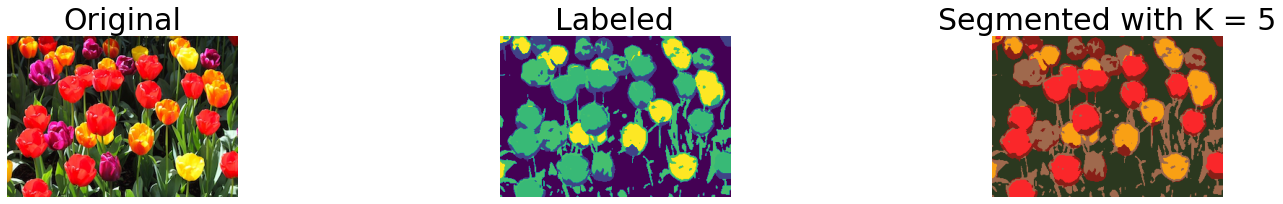

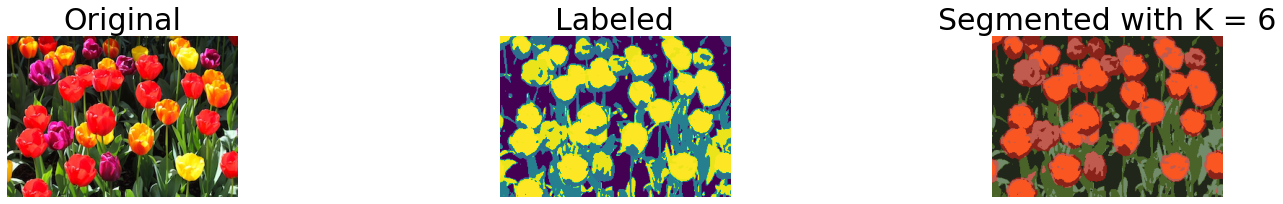

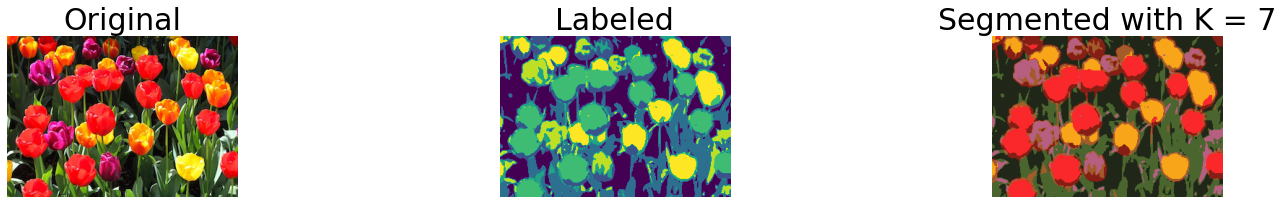

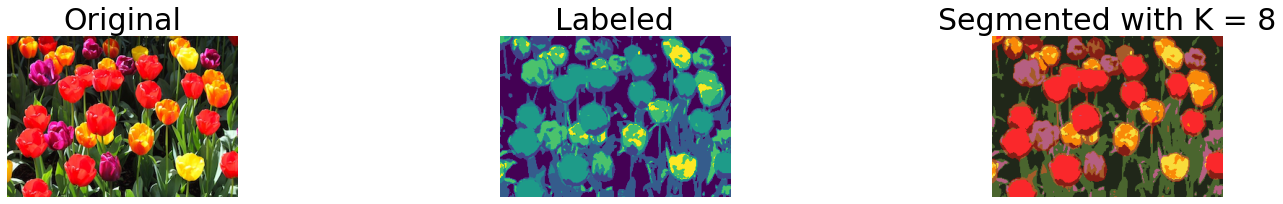

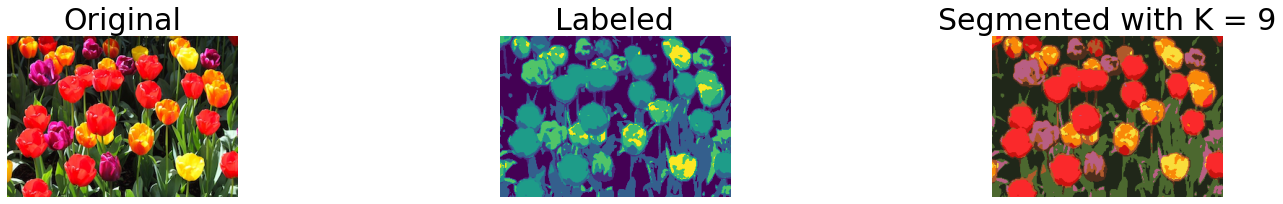

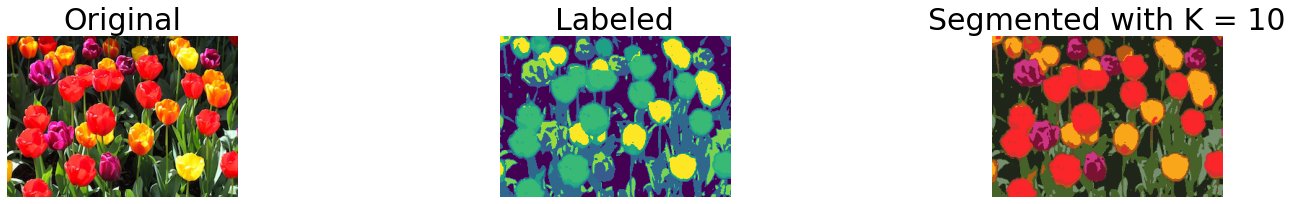

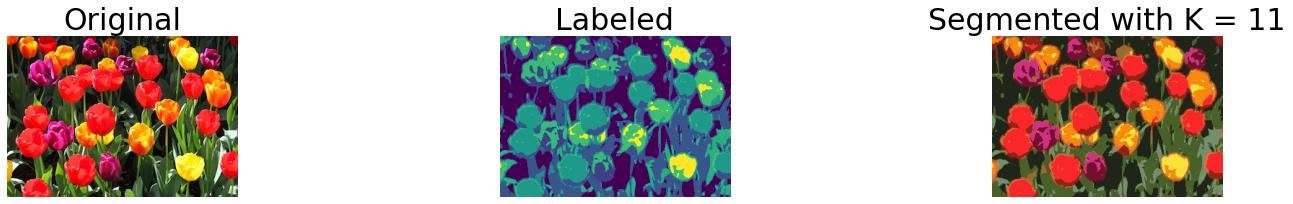

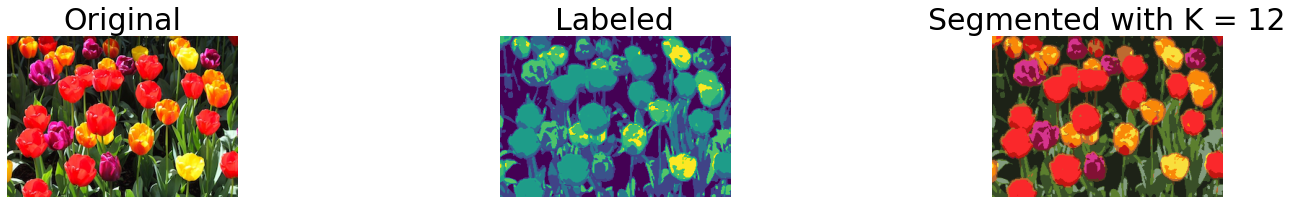

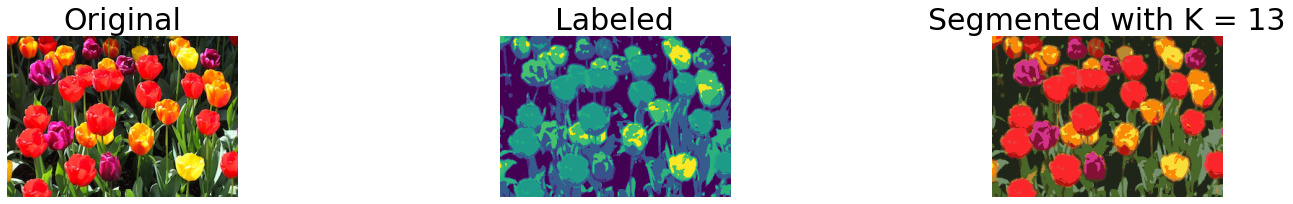

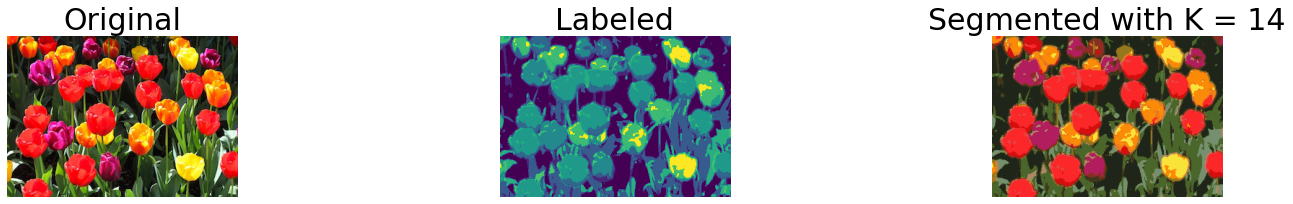

In [ ]:
K=7
epoch=500
epsilon=1e-6
Verbose = False
Graphing = False

#for bear
BIC_list =[]
n_components = np.arange(5,15)
t=0
for n in n_components:
  temp = GMM(n, verbose=Verbose, graphing = Graphing, epoch=epoch, epsilon=epsilon)
  temp.fit(flower_copy_blur)
  labeled_img = temp.predict_img(flower_copy_blur)
  labeled_img  = np.array(labeled_img * 255, dtype=int)

  labeled_img = labeled_img.reshape(flower_orig.shape) #
  # print(labeled_img.shape)

  fig = plt.figure(figsize=(25,35))
  
  t+=1
  fig.add_subplot(10, 3, t)
  plt.imshow(flower_orig) #
  plt.title("Original", fontsize=30)
  plt.axis('off')

  t+=1
  fig.add_subplot(10, 3, t)
  plt.imshow(np.mean(labeled_img, axis=-1))
  plt.title("Labeled", fontsize=30)
  plt.axis('off')
  
  t+=1
  fig.add_subplot(10, 3, t)
  plt.imshow(labeled_img)
  plt.title("Segmented with K = %d"% n, fontsize=30)
  plt.axis('off')


  BIC_list.append(temp.cost_Fucntion(bear_copy_blur))

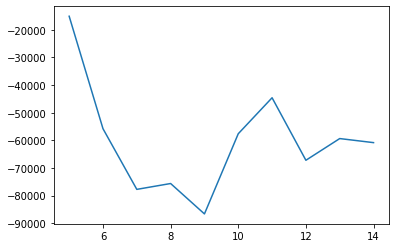

In [ ]:
plt.plot(n_components, BIC_list)
plt.show()

In [ ]:
# K=7
# epoch=100
# epsilon=1e-8

# BIC_list =[]
# n_components = np.arange(2,11)
# t=0
# for n in n_components:
#   t+=1
#   temp = GMM(n, verbose=False, graphing = False, epoch=epoch, epsilon=epsilon)
#   temp.fit(img)
#   labeled_img = temp.predict_img(img)
#   labeled_img  = np.array(labeled_img * 255, dtype=int)

#   labeled_img = labeled_img.reshape(img_orig.shape) #
#   # print(labeled_img.shape)

#   fig = plt.figure(figsize=(18,20))

#   fig.add_subplot(t, 3, 1)
#   plt.imshow(img_orig) #
#   plt.title("Original")
#   plt.axis('off')

#   fig.add_subplot(t, 3, 2)
#   plt.imshow(np.mean(labeled_img, axis=-1))
#   plt.title("Labeled")
#   plt.axis('off')

#   fig.add_subplot(t, 3, 3)
#   plt.imshow(labeled_img)
#   plt.title("Segmented")
#   plt.axis('off')


#   BIC_list.append(temp.cost_Fucntion(img))



In [ ]:
# plt.plot(n_components, BIC_list)
# plt.show()

# Creating a simple image

In [ ]:
    
# w, h = 512, 512
# data = np.zeros((h, w, 3), dtype=np.uint8)

# data[:,:] = [248,248,255]


# #red 
# data[412:512, 0:101] = [255,0 ,0]
# data[0:101,412:512] = [255,0 ,0]

# #brown
# data[0:101, 0:101] = [156,102,31]
# data[412:512, 412:512] = [156,102,31]

# #blue 
# data[0:200, 262:363] = [0,0,255]
# data[312:512, 150:250] = [0,0,255]

# #green
# data[0:200, 150:250] = [0,255,0]
# data[312:512, 262:363] = [0,255,0]

# #yellow
# data[250:262, :] = [255,255,0]

# simple  = Image.fromarray(data, 'RGB')
# simple_image = asarray(simple)

# #plot image
# plt.imshow(simple)
# plt.show()

# simple_img = simple_image.reshape(-1, 3)
# print(simple_image.shape)
# simple_img = simple_img/255

# print(simple_img)

# GMM for simple image with 5 different color

In [ ]:
# K = 7
# epoch = 40
# epsilon = 1e-5
# verbose = True
# graphing = True

# # BIC on simple image
# BIC_list =[]
# n_components = np.arange(2,11)
# for n in n_components:
#   temp = GMM(n, verbose=verbose, graphing=False, epoch=epoch, epsilon=epsilon)
#   temp.fit(simple_img)
#   BIC_list.append(temp.cost_Fucntion(simple_img))

# plt.plot(n_components, BIC_list)

# model = GMM(K, verbose, graphing, epoch, epsilon=epsilon)

# model.fit(simple_img) #
# labeled_img = model.predict_img(simple_img)#

# labeled_img  = np.array(labeled_img * 255, dtype=int)

# labeled_img = labeled_img.reshape(simple_image.shape) #
# # print(labeled_img.shape)

# fig = plt.figure(figsize=(18,20))

# fig.add_subplot(1, 3, 1)
# plt.imshow(simple_image) #
# plt.title("Original")
# plt.axis('off')

# fig.add_subplot(1, 3, 2)
# plt.imshow(np.mean(labeled_img, axis=-1))
# plt.title("Labeled")
# plt.axis('off')

# fig.add_subplot(1, 3, 3)
# plt.imshow(labeled_img)
# plt.title("Segmented")
# plt.axis('off')

## Using GMM model to extract labels

In [ ]:
# import numpy as np
# import cv2

# img = cv2.imread("bear-sample.jpg")
# img2 = img.reshape((-1,3))

# from sklearn.mixture import GaussianMixture as GMM

# n = 8
# gmm_model = GMM(n, covariance_type='tied').fit(img2)
# gmm_labels = gmm_model.predict(img2)
# # #Put numbers back to original shape so we can reconstruct segmented image
# original_shape = img.shape
# segmented = gmm_labels.reshape(original_shape[0], original_shape[1])
# plt.imshow(segmented)

## Initialization

In [ ]:
# K = 5
# epoch = 100
# epsilon = 1e-3
# verbose = False
# graphing = True

# BIC_list =[]
# n_components = np.arange(2,11)
# for n in n_components:
#   temp = GMM(n, verbose=verbose, graphing=False, epoch=epoch, epsilon=epsilon)
#   temp.fit(img)
#   BIC_list.append(temp.cost_Fucntion(img))

# plt.plot(n_components, BIC_list)

# model = GMM(K, verbose, graphing, epoch, epsilon=epsilon)

# model.fit(img) #
# labeled_img = model.predict_img(img)#

# labeled_img  = np.array(labeled_img * 255, dtype=int)
# # print(labeled_img.shape)
# # print(img_orig.shape)
# labeled_img = labeled_img.reshape(img_orig.shape) #
# # print(labeled_img.shape)

# fig = plt.figure(figsize=(18,20))

# fig.add_subplot(1, 3, 1)
# plt.imshow(img_orig) #
# plt.title("Original")
# plt.axis('off')

# fig.add_subplot(1, 3, 2)
# plt.imshow(np.mean(labeled_img, axis=-1))
# plt.title("Labeled")
# plt.axis('off')

# fig.add_subplot(1, 3, 3)
# plt.imshow(labeled_img)
# plt.title("Segmented")
# plt.axis('off')


simple image 2

In [ ]:
# K=7
# epoch=100
# epsilon=1e-8
# w, h = 512, 512
# data = np.zeros((h, w, 3), dtype=np.uint8)

# #red 
# data[0:256, 0:256] = [255,255,0] # upper left
# data[256:512, 0:256] = [255, 0, 0] # down left
# data[0:256, 256:512] = [0, 0, 255] # upper right
# data[256:512, 256:512] = [0, 255, 0] # down left

# simple2  = Image.fromarray(data, 'RGB')
# simple_image2= asarray(simple2)

# plt.imshow(simple2)
# plt.show()

# simple_img2 = simple_image2.reshape(-1, 3)
# simple_img2 = simple_img2/255

# #
# model = GMM(K, verbose=True, graphing=False, epoch=epoch, epsilon=epsilon)

# model.fit(simple_img2) #
# labeled_img = model.predict_img(simple_img2)#

# labeled_img  = np.array(labeled_img * 255, dtype=int)

# labeled_img = labeled_img.reshape(simple_image2.shape) #
# # print(labeled_img.shape)

# fig = plt.figure(figsize=(18,20))

# fig.add_subplot(1, 3, 1)
# plt.imshow(simple_image2) #
# plt.title("Original")
# plt.axis('off')

# fig.add_subplot(1, 3, 2)
# plt.imshow(np.mean(labeled_img, axis=-1))
# plt.title("Labeled")
# plt.axis('off')

# fig.add_subplot(1, 3, 3)
# plt.imshow(labeled_img)
# plt.title("Segmented")
# plt.axis('off')


# test

In [ ]:
# K=7
# epoch=100
# epsilon=1e-8
# w, h = 512, 512
# data = np.zeros((h, w, 3), dtype=np.uint8)

# #red 
# data[0:256, 0:256] = [255,255,0] # upper left
# data[256:512, 0:256] = [255, 0, 0] # down left
# data[0:256, 256:512] = [0, 0, 255] # upper right
# data[256:512, 256:512] = [0, 255, 0] # down left

# simple2  = Image.fromarray(data, 'RGB')
# simple_image2= asarray(simple2)

# plt.imshow(simple2)
# plt.show()

# simple_img2 = simple_image2.reshape(-1, 3)
# simple_img2 = simple_img2/255

# BIC_list =[]
# n_components = np.arange(2,11)
# t=0
# for n in n_components:
#   t+=1
#   temp = GMM(n, verbose=False, graphing = False, epoch=epoch, epsilon=epsilon)
#   temp.fit(simple_img2)
#   labeled_img = temp.predict_img(simple_img2)
#   labeled_img  = np.array(labeled_img * 255, dtype=int)

#   labeled_img = labeled_img.reshape(simple_image2.shape) #
#   # print(labeled_img.shape)

#   fig = plt.figure(figsize=(18,20))

#   fig.add_subplot(t, 3, 1)
#   plt.imshow(simple_image2) #
#   plt.title("Original")
#   plt.axis('off')

#   fig.add_subplot(t, 3, 2)
#   plt.imshow(np.mean(labeled_img, axis=-1))
#   plt.title("Labeled")
#   plt.axis('off')

#   fig.add_subplot(t, 3, 3)
#   plt.imshow(labeled_img)
#   plt.title("Segmented")
#   plt.axis('off')


#   BIC_list.append(temp.cost_Fucntion(simple_img2))

# plt.plot(n_components, BIC_list)
# plt.show()

In [ ]:
# plt.plot(n_components, BIC_list)
# plt.show()